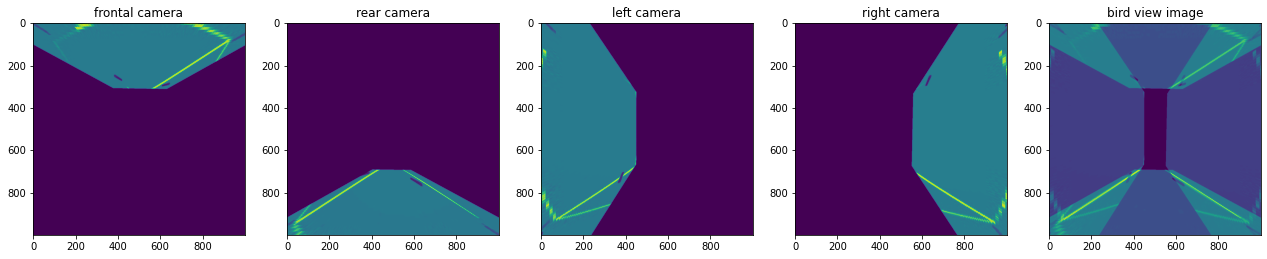

In [33]:
import numpy as np
from numpy.linalg import inv
import math
import time
import argparse
import yaml
import cv2
import sympy as sp
import os
from matplotlib import pyplot as plt

#SUBFUNCTION TO IMPORT THE RT MATRIX OBTAINED IN THE CALIBRATION|||||||||||||||||||||||||||||||||||||||||
def remap_data_loader(rt_path, fc1_path, vc1_path): 

    rt = rt_path  
    
    #INFO OF THE RT MATRIX:-------------------------------
    with open(rt) as a:                              

        data = yaml.load(a, Loader=yaml.FullLoader)   
        
    rt_mtx_info     =  data.get("rt_matrix")                  
    rt_inv_mtx_info =  data.get("rt_inverse_matrix")  
    rt_mtx          =  np.array(rt_mtx_info.get("data") )            
    rt_inv_mtx      =  np.array(rt_inv_mtx_info.get("data") )          
    fc1             =  fc1_path
    
    #INFO OF THE FISHEYE CAMERA:--------------------------
    with open(fc1) as b:  
    
        fc1 = yaml.load(b, Loader=yaml.FullLoader) 
        
    kc_sub_dic      =  fc1.get("camera_matrix")       
    kc_data_list    =  kc_sub_dic.get("data")          

    fax=kc_data_list[0];fay=kc_data_list[4];ua0=kc_data_list[2];va0=kc_data_list[5] 
    fc1_kc=np.array([[fax, 0, ua0],[0, fay, va0],[0,0,1]])                          
    fc1_kc_inv = inv(fc1_kc)                                                           

    #INFO OF THE VIRTUAL CAMERA:--------------------------
    vc1 = vc1_path
    with open(vc1) as c:  
    
        vc1 = yaml.load(c, Loader=yaml.FullLoader) 
        
    kcv_dic         =  vc1.get("virtual_cam_mtx")  
    kcv_data        =  kcv_dic.get("data")     
    inv_kcv_dic     =  vc1.get("virtual_cam_mtx_inv")  
    inv_kcv_data    =  inv_kcv_dic.get("data")         
    vc1_kc          =  np.array(kcv_data) 
    vc1_kc_inv      =  np.array(inv_kcv_data)    
    h_vir           =  vc1.get('h_vir')
    fov             =  vc1.get('fov')
    side_length     =  vc1.get('side_length')
    m_pixels        =  vc1.get('m_pixels')
    n_pixels        =  vc1.get('n_pixels')
     
        
    return (rt_mtx, rt_inv_mtx, fc1_kc, fc1_kc_inv, vc1_kc, vc1_kc_inv, h_vir, fov, side_length, m_pixels, n_pixels )    
#------------------------------------------------------------------------------------------------------
#||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||  
#SUBFUNTIONS FOR THE PIXEL WRAPPING--------------------------------------------------------------------
def pix2cor(px, h, kc_inv): 

    cor_1   =  np.matmul( (h*kc_inv), px )   
    return cor_1

def cor2pix(cor, h, kc):

    pix   =    np.matmul(( (1/h)*kc ), cor )
    return pix

def find_s_cor(v_cor, rt):
    
    s_cor   =  np.matmul(rt,v_cor)    
    return s_cor


#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
#FRONT IMAGE----------------------------------------------------------------------------------------------

rt_path      =  'yaml_config/b_calib_out_front.yaml'  
fc1_path     =  'yaml_config/left_ir.yaml'
vc1_path     =  'yaml_config/virtual_cam.yaml'
in_img_path  =  "output/front_v_img.jpg"

rt_mtx, rt_inv_mtx, fc1_kc, fc1_kc_inv, vc1_kc, vc1_kc_inv, h_vir, fov, side_length, m_pixels, n_pixels  = remap_data_loader(rt_path, fc1_path, vc1_path)

img   =  cv2.imread(in_img_path,cv2.COLOR_BGR2GRAY)   
v_img =  np.zeros((1000,1000), np.uint8)       

for u in range(0,1000):
    for v in range(0,500):
        
        v_pixel      =  np.array([[u],[v],[1]])     
        v_cordinate  =  pix2cor(v_pixel, h_vir, vc1_kc_inv)      
        s_cordinate  =  find_s_cor(v_cordinate, rt_mtx)         
        H_VAR        =  s_cordinate[2] 
        s_pix        =  cor2pix(s_cordinate, H_VAR, fc1_kc)                    
        s_pix_int    =  np.array([[s_pix[0]],[s_pix[1]]],np.uint16) 
             
        if s_pix[0] > 0 and s_pix[0] < 390 and s_pix[1] > 0 and s_pix[1] < 140:    

            v_img[v,u] = img[s_pix_int[1],s_pix_int[0]]       
            
        else:
            pass       
      
cv2.imwrite('output_mac/mac_front_img.jpg', v_img)

#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
#LEFT IMAGE-----------------------------------------------------------------------------------------------

rt_path      =  'yaml_config/b_calib_out_left.yaml'  
fc1_path     =  'yaml_config/left_ir.yaml'
vc1_path     =  'yaml_config/virtual_cam.yaml'
in_img_path  =  "output/left_v_img.jpg" 

rt_mtx, rt_inv_mtx, fc1_kc, fc1_kc_inv, vc1_kc, vc1_kc_inv, h_vir, fov, side_length, m_pixels, n_pixels  = remap_data_loader(rt_path, fc1_path, vc1_path)

img   =  cv2.imread(in_img_path,cv2.COLOR_BGR2GRAY)    
v_img =  np.zeros((1000,1000), np.uint8)       

for u in range(0,1000):
    for v in range(0,1000):
        
        v_pixel      =  np.array([[u],[v],[1]])        
        v_cordinate  =  pix2cor(v_pixel, h_vir, vc1_kc_inv)  
        s_cordinate  =  find_s_cor(v_cordinate, rt_mtx)     
        H_VAR        =  s_cordinate[2] 
        s_pix        =  cor2pix(s_cordinate, H_VAR, fc1_kc)             
        s_pix_int    =  np.array([[s_pix[0]],[s_pix[1]]],np.uint16)   
             
        #if s_pix[0] > 0 and s_pix[0] < 390 and s_pix[1] > -140 and s_pix[1] < 140:#   
        if s_pix[0] > 0 and s_pix[0] < 390 and s_pix[1] > 0 and s_pix[1] < 140: 
            v_img[v,u] = img[s_pix_int[1],s_pix_int[0]] ###<------------REMEMBER, TO GET VALUE FROM IMG IS ORDERED BY Y,X INSTEAD X,Y          
                
        else:
            pass            
            
cv2.imwrite('output_mac/mac_left_img.jpg', v_img)

#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
#RIGHT IMAGE-----------------------------------------------------------------------------------------------

rt_path      =  'yaml_config/b_calib_out_right.yaml'  
fc1_path     =  'yaml_config/left_ir.yaml'
vc1_path     =  'yaml_config/virtual_cam.yaml'
in_img_path  =  "output/right_v_img.jpg" 

rt_mtx, rt_inv_mtx, fc1_kc, fc1_kc_inv, vc1_kc, vc1_kc_inv, h_vir, fov, side_length, m_pixels, n_pixels  = remap_data_loader(rt_path, fc1_path, vc1_path)

img   =  cv2.imread(in_img_path,cv2.COLOR_BGR2GRAY)    
v_img =  np.zeros((1000,1000), np.uint8)       

for u in range(0,1000):
    for v in range(0,1000):
        
        v_pixel      =  np.array([[u],[v],[1]])        
        v_cordinate  =  pix2cor(v_pixel, h_vir, vc1_kc_inv)  
        s_cordinate  =  find_s_cor(v_cordinate, rt_mtx)     
        H_VAR        =  s_cordinate[2] 
        s_pix        =  cor2pix(s_cordinate, H_VAR, fc1_kc)             
        s_pix_int    =  np.array([[s_pix[0]],[s_pix[1]]],np.uint16)   
             
        if s_pix[0] > 0 and s_pix[0] < 390 and s_pix[1] > 0 and s_pix[1] < 140:  
        
            v_img[v,u] = img[s_pix_int[1],s_pix_int[0]] ###<------------REMEMBER, TO GET VALUE FROM IMG IS ORDERED BY Y,X INSTEAD X,Y          
                
        else:
            pass            
            
cv2.imwrite('output_mac/mac_right_img.jpg', v_img)

#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
#BACK IMAGE-----------------------------------------------------------------------------------------------

rt_path      =  'yaml_config/b_calib_out_back.yaml'  
fc1_path     =  'yaml_config/left_ir.yaml'
vc1_path     =  'yaml_config/virtual_cam.yaml'
in_img_path  =  "output/back_v_img.jpg" 

rt_mtx, rt_inv_mtx, fc1_kc, fc1_kc_inv, vc1_kc, vc1_kc_inv, h_vir, fov, side_length, m_pixels, n_pixels  = remap_data_loader(rt_path, fc1_path, vc1_path)

img   =  cv2.imread(in_img_path,cv2.COLOR_BGR2GRAY)    
v_img =  np.zeros((1000,1000), np.uint8)       

for u in range(0,1000):
    for v in range(0,1000):
        
        v_pixel      =  np.array([[u],[v],[1]])        
        v_cordinate  =  pix2cor(v_pixel, h_vir, vc1_kc_inv)  
        s_cordinate  =  find_s_cor(v_cordinate, rt_mtx)     
        H_VAR        =  s_cordinate[2] 
        s_pix        =  cor2pix(s_cordinate, H_VAR, fc1_kc)             
        s_pix_int    =  np.array([[s_pix[0]],[s_pix[1]]],np.uint16)   
             
        if s_pix[0] > 0 and s_pix[0] < 390 and s_pix[1] > 0 and s_pix[1] < 140:
        
            v_img[v,u] = img[s_pix_int[1],s_pix_int[0]] ###<------------REMEMBER, TO GET VALUE FROM IMG IS ORDERED BY Y,X INSTEAD X,Y          
                
        else:
            pass            
            
cv2.imwrite('output_mac/mac_back_img.jpg', v_img)

#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
#JOIN IMAGES----------------------------------------------------------------------------------------------

mask  = np.zeros((1000,1000), np.uint8) 

front = cv2.imread("output_mac/mac_front_img.jpg" ,cv2.COLOR_BGR2GRAY) 
left  = cv2.imread("output_mac/mac_left_img.jpg"  ,cv2.COLOR_BGR2GRAY) 
right = cv2.imread("output_mac/mac_right_img.jpg" ,cv2.COLOR_BGR2GRAY) 
back  = cv2.imread("output_mac/mac_back_img.jpg"  ,cv2.COLOR_BGR2GRAY) 

out = cv2.addWeighted(front,0.4,left,0.3, 0)
out = cv2.addWeighted(out,1,right,0.3, 0)
out = cv2.addWeighted(out,1,back,0.4, 0)

cv2.imwrite('output_mac/mac_view.jpg', out)

#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
#OPTIONAL SECTION TO CHECK--------------------------------------------------------------------------------
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (22, 22),  sharey=False)

ax1.set_title('frontal camera');  ax2.set_title('rear camera'); ax3.set_title('left camera'); ax4.set_title('right camera');  ax5.set_title('bird view image')

ax1.imshow(front); ax2.imshow(back); ax3.imshow(left);  ax4.imshow(right);  ax5.imshow(out)  